### Model for count data

Based on Ch.1.4. from [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/).

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
filename = 'txtdata.csv'

! wget -qN https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/{filename}

obs_data = np.loadtxt(filename)
print(f"{obs_data.shape = }")

! rm {filename}

SSL_INIT
obs_data.shape = (74,)


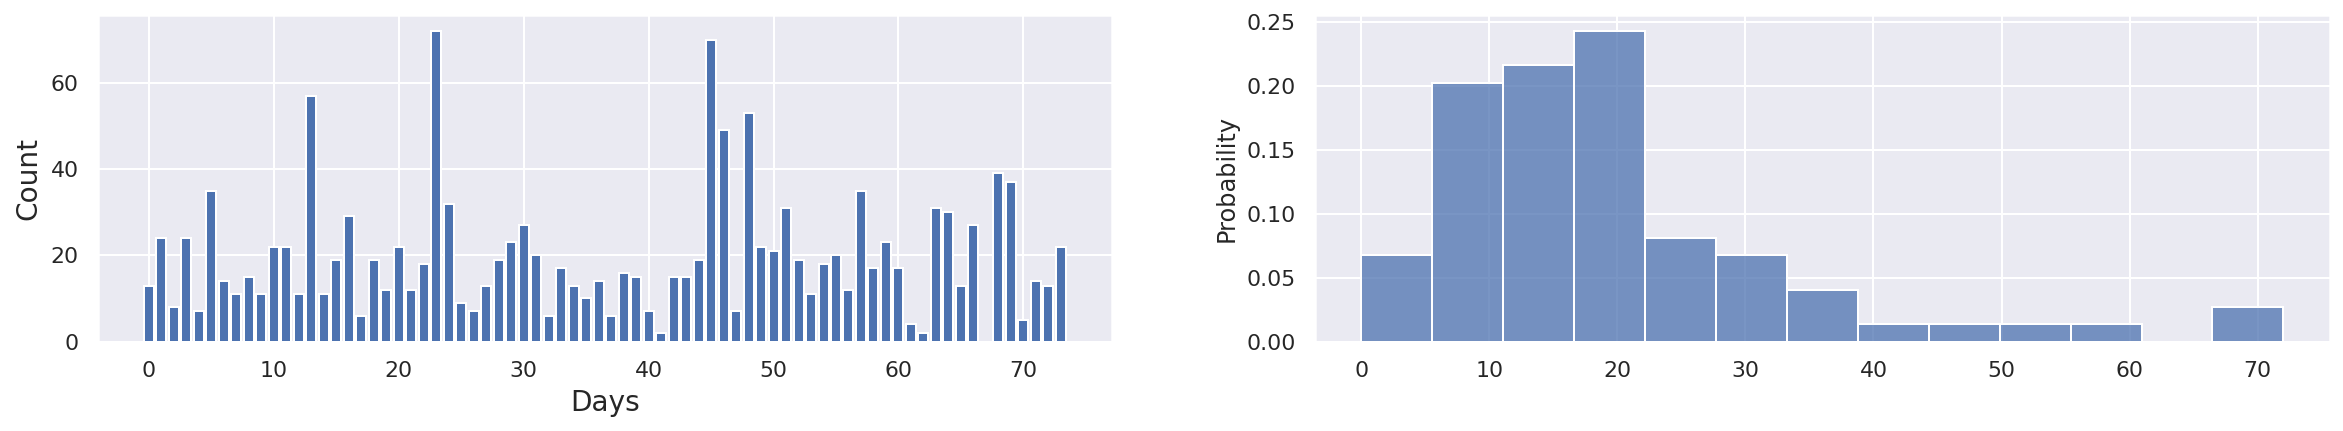

In [3]:
plt.figure(figsize=(20, 3))

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(obs_data)), obs_data)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.subplot(1, 2, 2)
sns.histplot(obs_data, stat='probability')
pass

The question is:

**Did the user’s texting habits change over time?**

We start by modelling the count for each day as a random variable $C_t \sim \mathsf{Poisson}(\lambda)$.

We further hypothesize that the rate $\lambda$ increases somewhere in the second half of the data. Thus, we can introduce a _switchpoint_ $\tau$:

$$
\lambda = \left\{
    \begin{array}{ll}
    \lambda_1, & t < \tau \\
    \lambda_2, & t \geq \tau
    \end{array}
\right.
$$

If there's no change at all, then we would expect $\lambda_1 = \lambda_2$ (and $\tau$ can be virtually any point between $t=\overline{1 \dots T}$).

Next, we need to choose the priors over $\lambda_1, \lambda_2, \tau$:
$$
\begin{array}{ll}
\lambda_1 &\sim \mathsf{Exp}(\alpha) \\
\lambda_2 &\sim \mathsf{Exp}(\alpha) \\
\tau &\sim \mathsf{DiscreteUniform}(1, T)
\end{array}
$$
A good initial guess for the hyperparameter $\alpha$ is $\dfrac{1}{\frac{1}{T}\sum_{t=1}^T C_t}$, since the inverse of the mean of the observed data is $\mathbb{E}[\lambda\mid\alpha] = \dfrac1\alpha$

### Define model

In [4]:
with pm.Model() as model:
    alpha = 1 / obs_data.mean()

    lam1 = pm.Exponential("lam1", alpha)
    lam2 = pm.Exponential("lam2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=1, upper=len(obs_data) - 1)
    
    idx = np.arange(len(obs_data))
    lam = pm.math.switch(tau > idx, lam1, lam2)
    
    obs = pm.Poisson("obs", lam, observed=obs_data)

### Perform inference

In [5]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(
        50_000, tune=10_000, step=step, return_inferencedata=False
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lam2]
>Metropolis: [lam1]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 37 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Plot posteriors

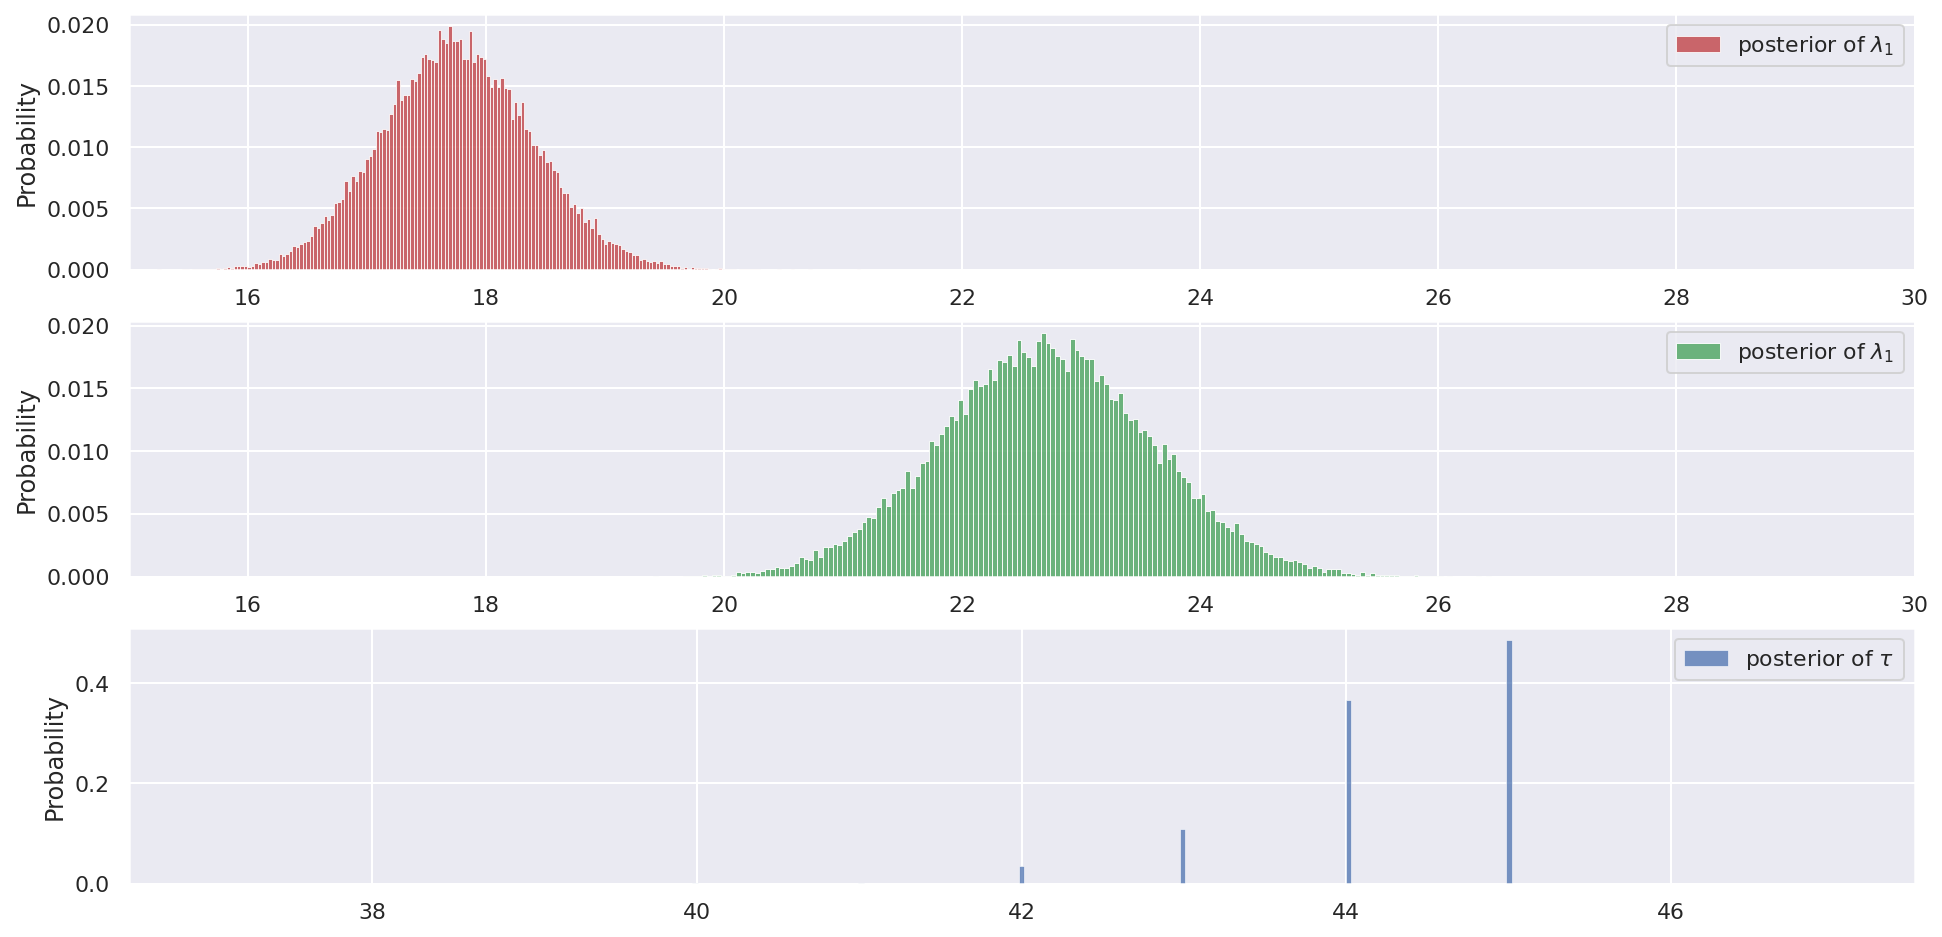

In [6]:
lam1_samples = trace['lam1']
lam2_samples = trace['lam2']
tau_samples = trace['tau']

plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1)
sns.histplot(lam1_samples, alpha=0.85, label="posterior of $\lambda_1$", color='r', stat='probability')
plt.xlim([15, 30])
plt.legend()

plt.subplot(3, 1, 2)
sns.histplot(lam2_samples, alpha=0.85, label="posterior of $\lambda_1$", color='g', stat='probability')
plt.xlim([15, 30])
plt.legend()

plt.subplot(3, 1, 3)
sns.histplot(tau_samples, stat='probability', label=r"posterior of $\tau$")
plt.legend()

pass

In [7]:
for τ in range(40, 51):
    mean_before = obs_data[:τ].mean()
    mean_after = obs_data[τ:].mean()

    print(f"({τ=}) {mean_before=:6.3f} -> {mean_after=:6.3f} (Δ={mean_after - mean_before:6.3f})")

(τ=40) mean_before=18.525 -> mean_after=21.176 (Δ= 2.651)
(τ=41) mean_before=18.244 -> mean_after=21.606 (Δ= 3.362)
(τ=42) mean_before=17.857 -> mean_after=22.219 (Δ= 4.362)
(τ=43) mean_before=17.791 -> mean_after=22.452 (Δ= 4.661)
(τ=44) mean_before=17.727 -> mean_after=22.700 (Δ= 4.973)
(τ=45) mean_before=17.756 -> mean_after=22.828 (Δ= 5.072)
(τ=46) mean_before=18.891 -> mean_after=21.143 (Δ= 2.252)
(τ=47) mean_before=19.532 -> mean_after=20.111 (Δ= 0.579)
(τ=48) mean_before=19.271 -> mean_after=20.615 (Δ= 1.345)
(τ=49) mean_before=19.959 -> mean_after=19.320 (Δ=-0.639)
(τ=50) mean_before=20.000 -> mean_after=19.208 (Δ=-0.792)


### Conclusion

- We conclude that indeed there may be a splitting point (most likely @ $\tau$ = 45, with proba 0.48853)
- Had no change occurred, we'd expect a more spread-out posterior of $\tau$ (i.e. more values of $\tau$ would have been plausible)
- Before the split we obtain a $\mathsf{Poisson}(\lambda_1\approx17.75)$
- After the split we obtain a $\mathsf{Poisson}(\lambda_1\approx22.7)$
- We are more confident in the posterior of $\lambda_1$, since it's narrower (less variance)